<a href="https://colab.research.google.com/github/M0hammad-Kashif/Notebooks/blob/main/Bankruptcy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://drive.google.com/file/d/14Ihki_x-v05lGqaSDFwHSFK4hQ2vuW_o/view?usp=sharing

--2022-05-12 12:32:34--  https://drive.google.com/file/d/14Ihki_x-v05lGqaSDFwHSFK4hQ2vuW_o/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.98.102, 142.250.98.100, 142.250.98.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.98.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  62.87K  --.-KB/s    in 0.001s  

2022-05-12 12:32:34 (60.7 MB/s) - ‘view?usp=sharing’ saved [64375]



In [6]:
!unzip '/content/data.zip'


Archive:  /content/data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/data.zip or
        /content/data.zip.zip, and cannot find /content/data.zip.ZIP, period.


In [11]:
%%capture
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Basic Libraries for Data organization, Statistical operations and Plotting
import numpy as np
import pandas as pd
%matplotlib inline
# For loading .arff files
from scipy.io import arff
# To analyze the type of missing data
import missingno as msno
# Library for performing k-NN and MICE imputations 
!pip install fancyimpute
import fancyimpute
# Library to perform Expectation-Maximization (EM) imputation
!pip install impyute
import impyute as impy
# To perform mean imputation
from sklearn.impute import SimpleImputer
#To perform kFold Cross Validation
from sklearn.model_selection import KFold
# Formatted counter of class labels
from collections import Counter
# Ordered Dictionary
from collections import OrderedDict
# Library imbalanced-learn to deal with the data imbalance. To use SMOTE oversampling
from imblearn.over_sampling import SMOTE 

# Impoting classification models
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [33]:
############################################################
# Loads the 5 raw .arff files into a list
def load_arff_raw_data():
    N=5
    return [arff.loadarff('/content/' + str(i+1) + 'year.arff') for i in range(N)]

############################################################
# Loads the 5 raw .arff files into pandas dataframes
def load_dataframes():
    return [pd.DataFrame(data_i_year[0]) for data_i_year in load_arff_raw_data()]

############################################################
# Set the column headers from X1 ... X64 and the class label as Y, for all the 5 dataframes.
def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('Y')
    for df in dataframes:
        df.columns = cols

############################################################
# dataframes is the list of pandas dataframes for the 5 year datafiles.  
dataframes = load_dataframes()

# Set the new headers for the dataframes. The new headers will have the renamed set of feature (X1 to X64)
set_new_headers(dataframes)    

# print the first 5 rows of a dataset 'year1'
dataframes[0].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [34]:
type(dataframes)

list

In [35]:
# Convert the dtypes of all the columns (other than the class label columns) to float.
def convert_columns_type_float(dfs):
    for i in range(5):
        index = 1
        while(index<=63):
            colname = dfs[i].columns[index]
            col = getattr(dfs[i], colname)
            dfs[i][colname] = col.astype(float)
            index+=1
            
convert_columns_type_float(dataframes)  

In [36]:
for i in range(len(dataframes)):
  print(f"Unique columns in year {i+1} is {dataframes[i]['Y'].unique()}")

Unique columns in year 1 is [b'0' b'1']
Unique columns in year 2 is [b'0' b'1']
Unique columns in year 3 is [b'0' b'1']
Unique columns in year 4 is [b'0' b'1']
Unique columns in year 5 is [b'0' b'1']


In [37]:
# The class labels for all the dataframes are originally in object type.
# Convert them to int types
def convert_class_label_type_int(dfs):
    for i in range(len(dfs)):
        col = getattr(dfs[i], 'Y')
        dfs[i]['Y'] = col.astype(int)
        
convert_class_label_type_int(dataframes)

In [38]:
############################################################
# Get Clean dataframes by dropping all the rows which have missing values
def drop_nan_rows(dataframes, verbose=False):
    clean_dataframes = [df.dropna(axis=0, how='any') for df in dataframes]
    if verbose:
        for i in range(len(dataframes)):
            print(str(i+1)+'year:','Original Length=', len(dataframes[i]), '\tCleaned Length=', len(clean_dataframes[i]), '\tMissing Data=', len(dataframes[i])-len(clean_dataframes[i]))
    return clean_dataframes

# Doing a quick analysis of how many missing values are there in each of the 5 dataframes
nan_dropped_dataframes = drop_nan_rows(dataframes, verbose=True)

1year: Original Length= 7027 	Cleaned Length= 3194 	Missing Data= 3833
2year: Original Length= 10173 	Cleaned Length= 4088 	Missing Data= 6085
3year: Original Length= 10503 	Cleaned Length= 4885 	Missing Data= 5618
4year: Original Length= 9792 	Cleaned Length= 4769 	Missing Data= 5023
5year: Original Length= 5910 	Cleaned Length= 3031 	Missing Data= 2879


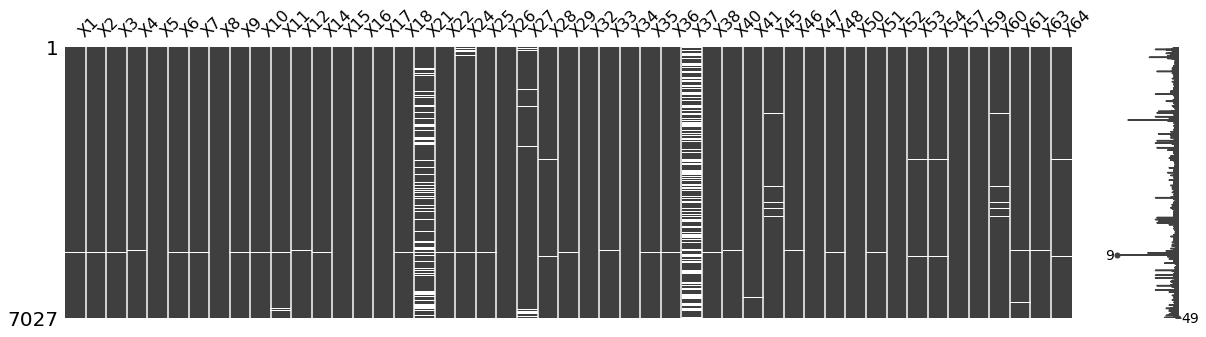

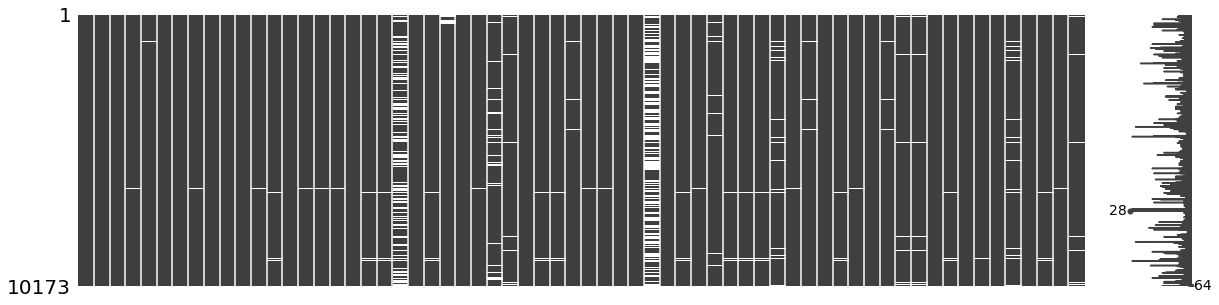

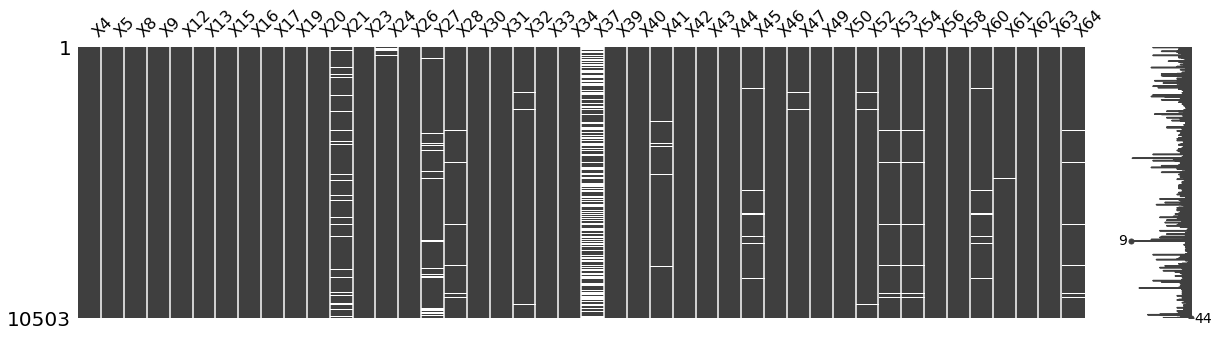

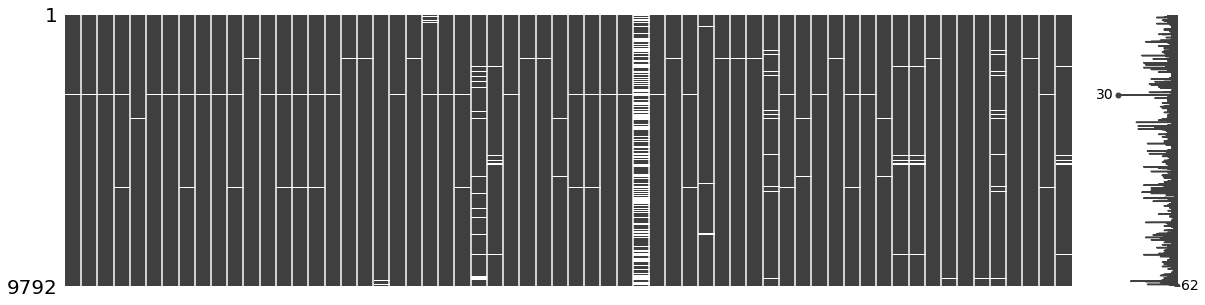

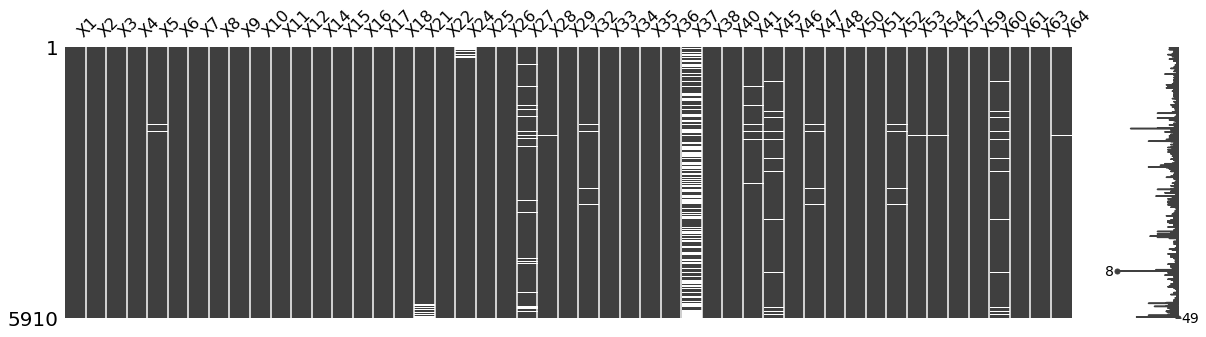

In [39]:
# generate the sparsity matrix (figure) for all the dataframes
def generate_sparsity_matrix(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.matrix(dfs[i][missing_df_i], figsize=(20,5))

generate_sparsity_matrix(dataframes)

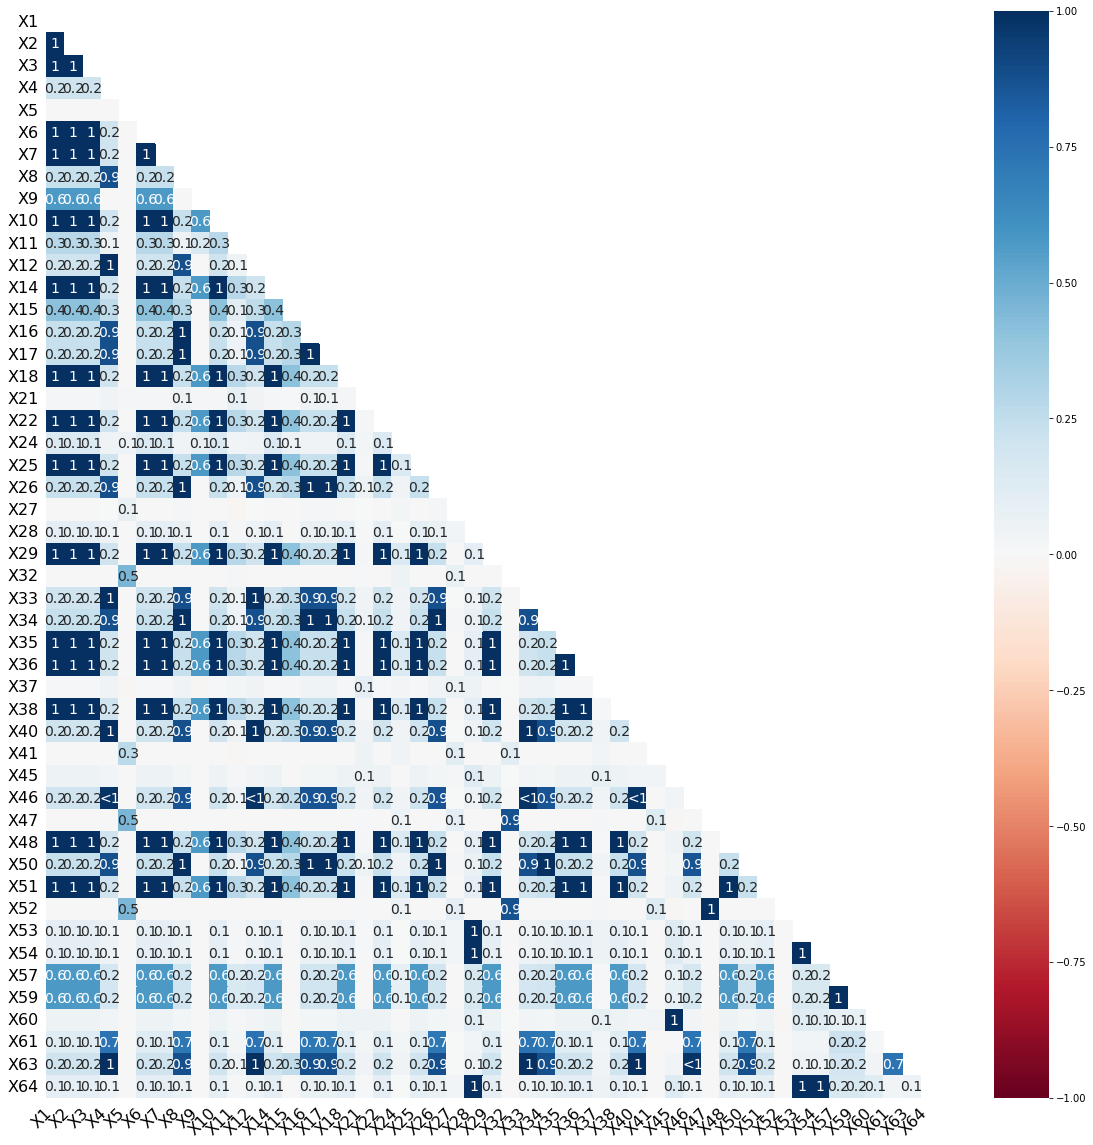

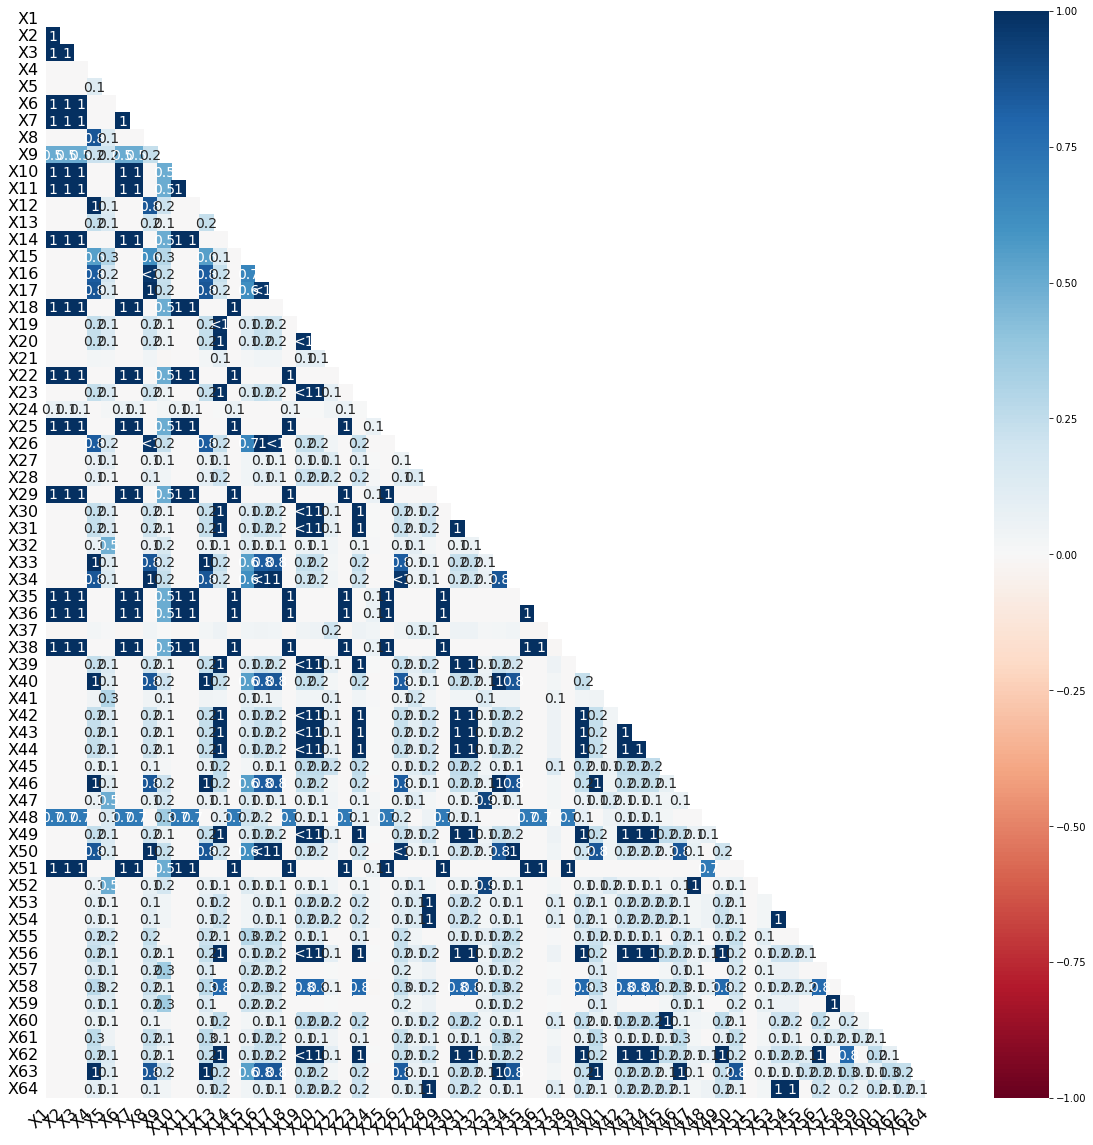

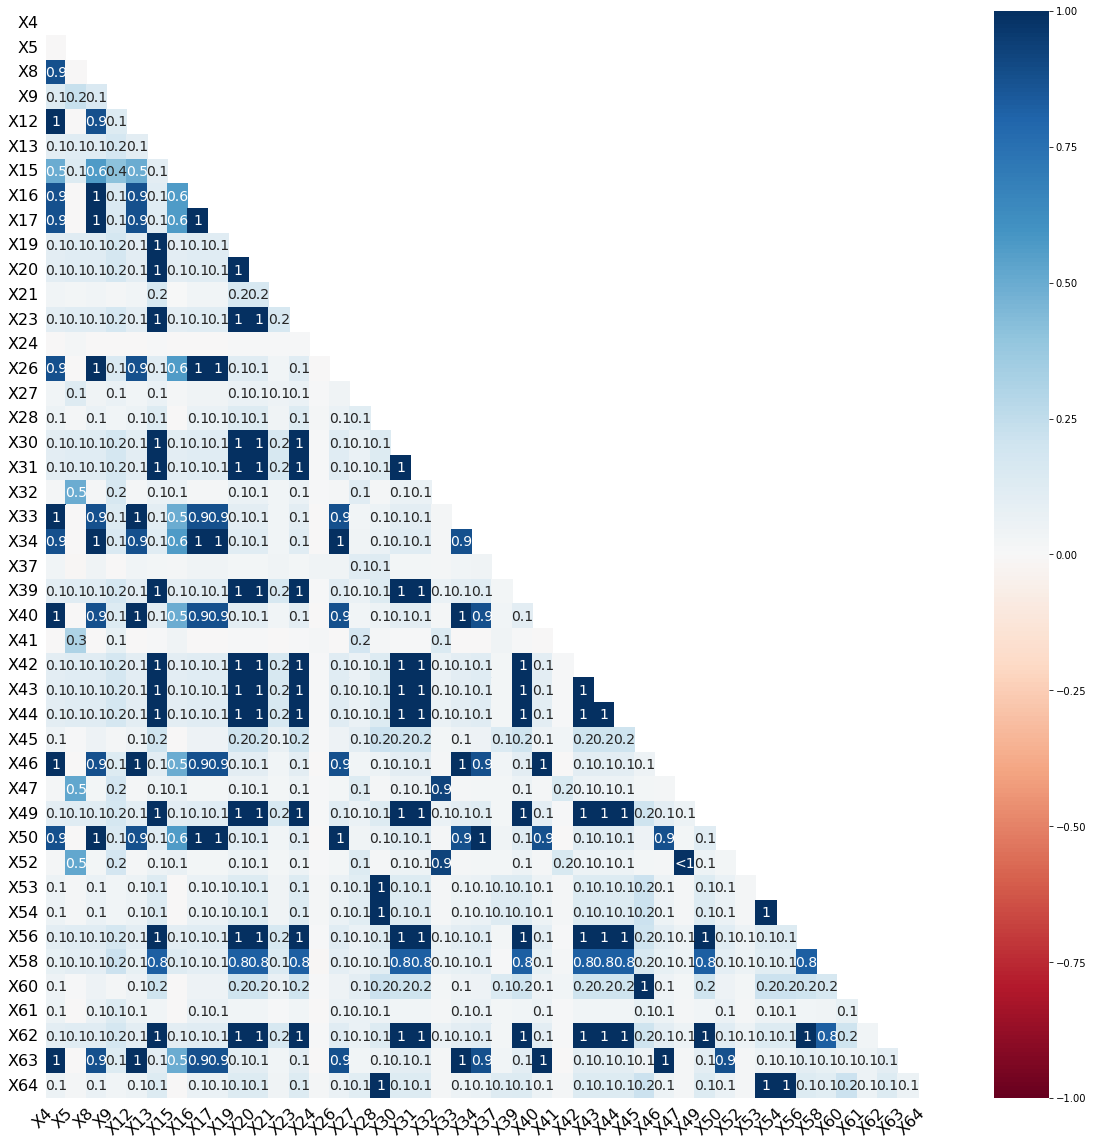

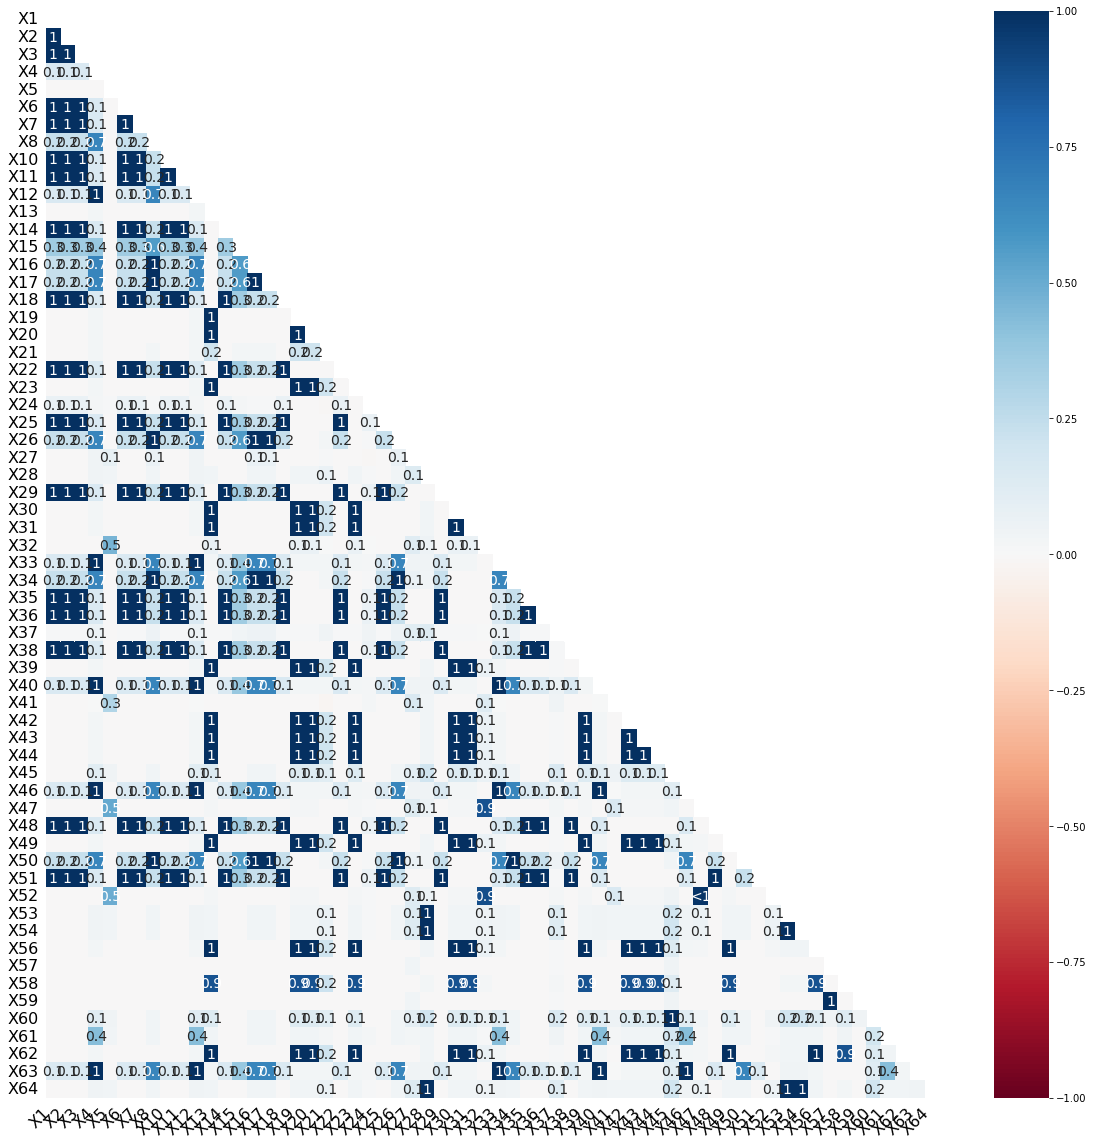

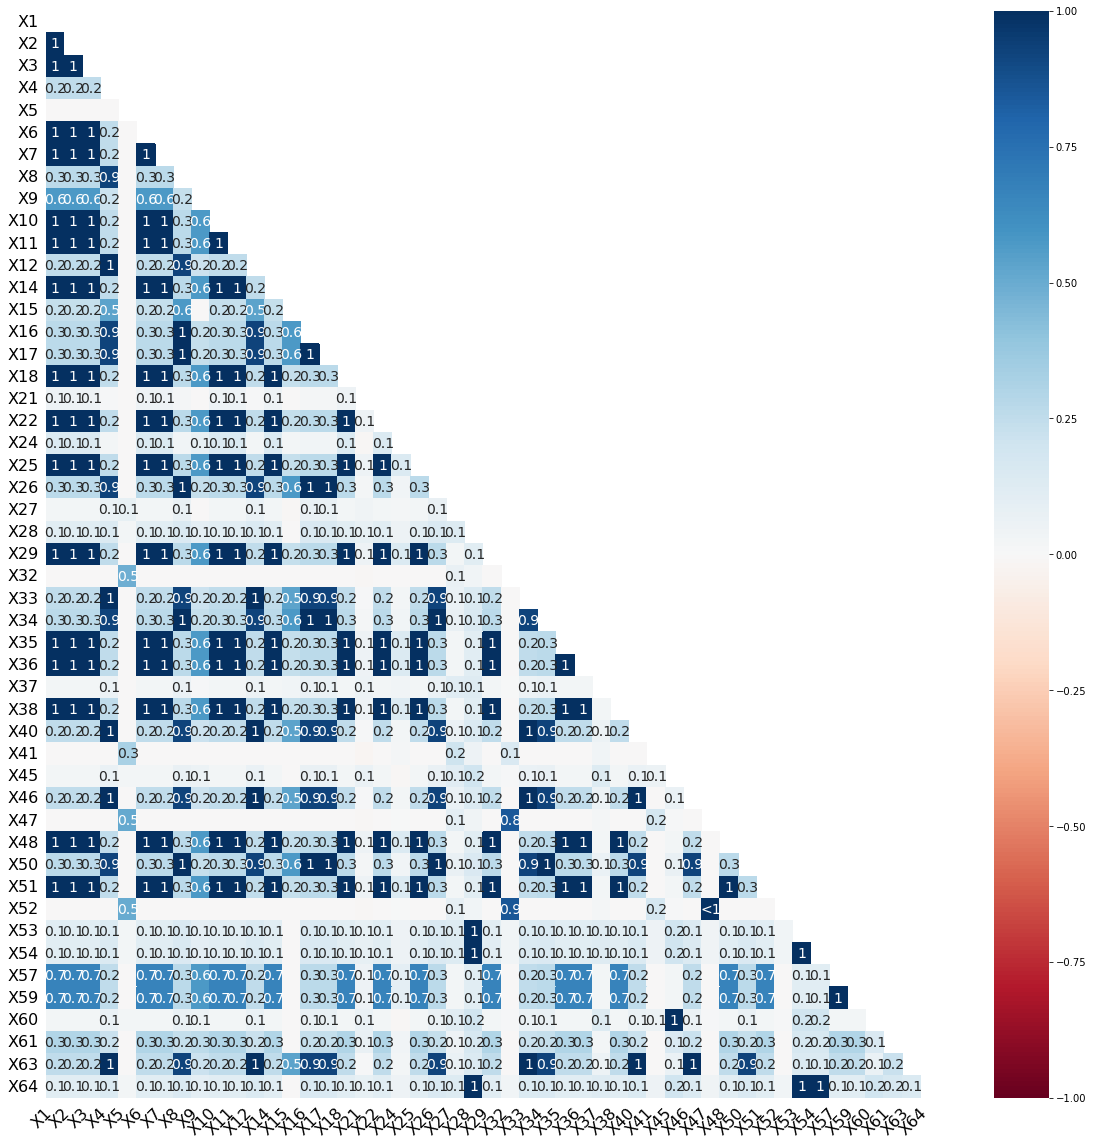

In [40]:
# generate the heatmap for all the dataframes
def generate_heatmap(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.heatmap(dfs[i][missing_df_i], figsize=(20,20))
        
generate_heatmap(dataframes) 

In [41]:
def perform_mean_imputation(dfs):
    # Construct an imputer with strategy as 'mean', to mean-impute along the columns
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    mean_imputed_dfs = [pd.DataFrame(imputer.fit_transform(df)) for df in dfs]
    for i in range(len(dfs)):
        mean_imputed_dfs[i].columns = dfs[i].columns   
    return mean_imputed_dfs

mean_imputed_dataframes = perform_mean_imputation(dataframes)

In [43]:
def perform_knn_imputation(dfs):
    knn_imputed_datasets = [fancyimpute.KNN(k=100,verbose=True).fit_transform(dfs[i]) for i in range(len(dfs))]
    # X_filled_knn = KNN(k=3).fit_transform(df_OppLine[['family']])
    return [pd.DataFrame(data=knn_imputed_datasets[i]) for i in range(len(dfs))]
    
knn_imputed_dataframes = perform_knn_imputation(dataframes)
set_new_headers(knn_imputed_dataframes)

Imputing row 1/7027 with 0 missing, elapsed time: 21.217
Imputing row 101/7027 with 1 missing, elapsed time: 21.225
Imputing row 201/7027 with 2 missing, elapsed time: 21.234
Imputing row 301/7027 with 0 missing, elapsed time: 21.242
Imputing row 401/7027 with 0 missing, elapsed time: 21.247
Imputing row 501/7027 with 1 missing, elapsed time: 21.254
Imputing row 601/7027 with 1 missing, elapsed time: 21.260
Imputing row 701/7027 with 1 missing, elapsed time: 21.267
Imputing row 801/7027 with 0 missing, elapsed time: 21.273
Imputing row 901/7027 with 0 missing, elapsed time: 21.279
Imputing row 1001/7027 with 1 missing, elapsed time: 21.286
Imputing row 1101/7027 with 1 missing, elapsed time: 21.292
Imputing row 1201/7027 with 3 missing, elapsed time: 21.300
Imputing row 1301/7027 with 1 missing, elapsed time: 21.309
Imputing row 1401/7027 with 1 missing, elapsed time: 21.315
Imputing row 1501/7027 with 1 missing, elapsed time: 21.323
Imputing row 1601/7027 with 1 missing, elapsed time: